# **Agents**

**Architecture**:

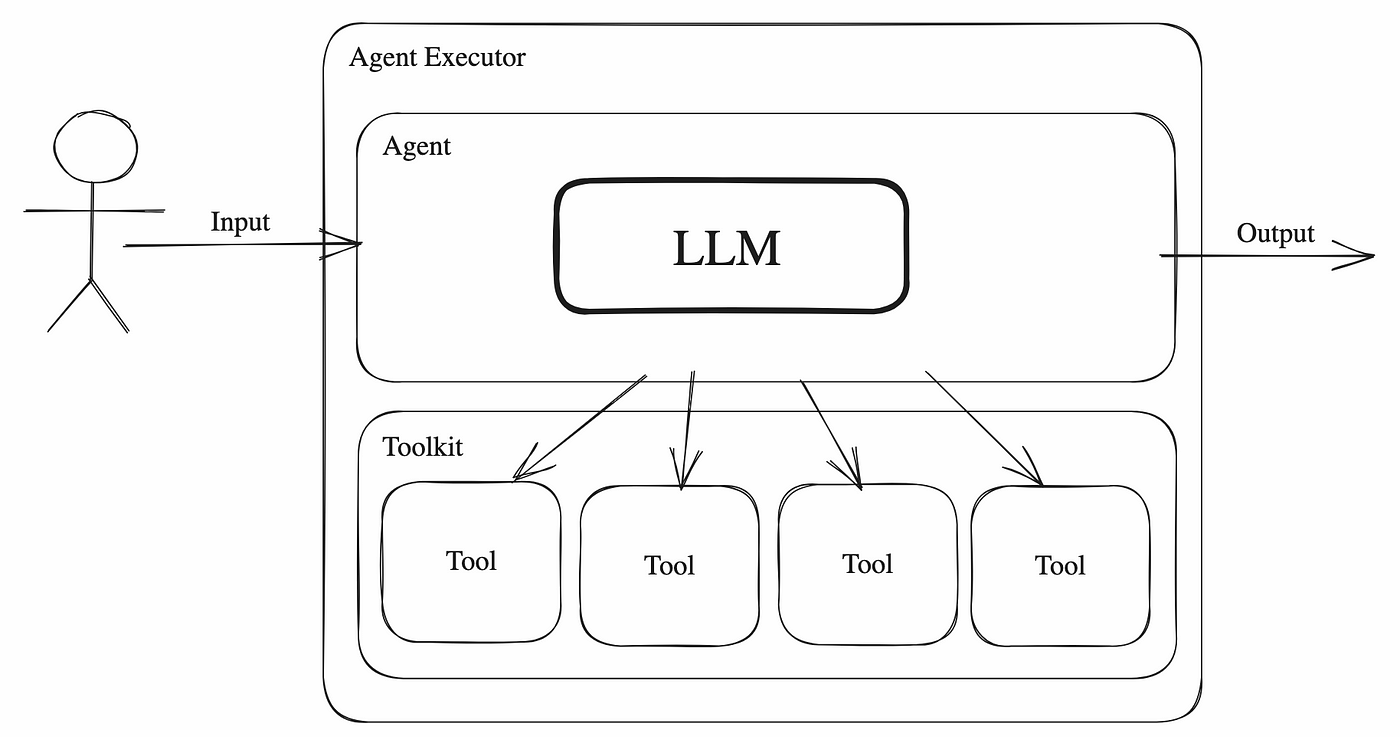

I will load my API keys.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

Or you could uncomment and run code below to use *getpass* instead:

In [6]:
#import os
#from getpass import getpass
#from uuid import uuid4
# Set environment variables
#os.environ["HUGGINGFACE_HUB_API_KEY"] = getpass("Enter your HUGGINGFACE_HUB_API_KEY:")
#print("-"*40)

#unique_id = uuid4().hex[0:8]

#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#print("-"*40)
#os.environ["LANGCHAIN_API_KEY"] = getpass("Enter your LANGCHAIN_API_KEY: ")
#os.environ["LANGCHAIN_PROJECT"] = f"Blaq's PDF Chatbot - {unique_id}"
#print("-"*40)
#os.environ["OPENAI_API_KEY"] = getpass("Enter your OPENAI_API_KEY:")

In [ ]:
# Download PDF file
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

Now, I will load the vector database initially saved locally:

In [2]:
import os
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# Check if there is a FAISS index locally
index_path = "faiss_index"
if os.path.exists(index_path):
    # Load the existing FAISS index
    hf = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local(index_path, hf, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
else:
    # Load the document and create embeddings
    loader = PyMuPDFLoader(input(""))
    text_data = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=20,
        length_function=len,
        is_separator_regex=False
    )
    chunks = text_splitter.split_documents(text_data)
    hf = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(chunks, hf)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
    # Save the FAISS index locally
    vectorstore.save_local(index_path)

c:\Users\Odiaka\miniconda3\envs\rag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Odiaka\miniconda3\envs\rag\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

# Create a compressed retriever
compressor = CohereRerank(top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

### Create your tools
I will be using just two tools for this implementation; one for querying my vector database, the other for any other questions aimed at information not present in my database. 

I will be using [**Tavily**](https://docs.tavily.com/docs/tavily-api/langchain) for external knowledge queries.

In [6]:
! pip install -qU tavily-python

In [7]:
import getpass
import os

if "TAVILY_API_KEY" not in os.environ:
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Provide your Tavily Search Api Key here: ")
  print("TAVILY_API_KEY successfully sent to the environment")

TAVILY_API_KEY successfully sent to the environment


In [8]:
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools.tavily_search import TavilySearchResults


retrieval_tool = create_retriever_tool(
    compression_retriever,
    "search_database",
    "Searches and returns excerpts from the database.",
)

web_search_tool = TavilySearchResults(max_results=3)

# define the tools
tools = [retrieval_tool, web_search_tool]

I will just pull a prompt, from Langchain hub, that does something closely related to what I want.

In [9]:
from langchain import hub

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-tools-agent")
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


Define the LLM

In [10]:
! pip install --quiet --upgrade langchain-openai

In [11]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0)

Create the agent

In [12]:
from langchain.agents import AgentExecutor, create_openai_tools_agent

agent = create_openai_tools_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)

Test it

In [13]:
result = agent_executor.invoke({"input": "Where is Nigeria?"})

In [14]:
result["output"]

'Nigeria is a country located in West Africa. It is bordered by Niger to the north, Chad to the northeast, Cameroon to the east, and Benin to the west. Nigeria also has a coastline along the Gulf of Guinea to the south.'

Almost perfect!

In [15]:
result = agent_executor.invoke({"input": "what are macronutrients?"})
result["output"]

"Macronutrients are essential nutrients that provide energy and are required in large amounts by the body for growth, metabolism, and overall health. There are three main types of macronutrients:\n\n1. Carbohydrates: Carbohydrates are the body's primary source of energy. They are found in foods like fruits, vegetables, grains, and legumes. Carbohydrates are broken down into glucose, which is used by the body for energy.\n\n2. Proteins: Proteins are essential for building and repairing tissues, as well as for various functions in the body. They are made up of amino acids and are found in foods like meat, poultry, fish, dairy products, nuts, and seeds.\n\n3. Fats: Fats are another source of energy for the body and are important for absorbing certain vitamins and maintaining cell membranes. They are found in foods like oils, butter, nuts, and avocados.\n\nBalancing the intake of these macronutrients is important for maintaining a healthy diet and overall well-being."

In [20]:
result = agent_executor.invoke({"input": "Is today monday?"})
result["output"]

'Today is Friday, not Monday.'

Wooosh! That was lightning fast. That is a state-of-the-art model right there.

We are eagerly anticipating further advancements in the realm of Retrieval Augmented Generation. If you're interested in exploring an alternative to Langchain, you may want to check out Semantic Kernel, a platform developed by Microsoft. The concept of plug-ins opens up a whole new world of possibilities. For more information, you can know more about it [**here**](https://github.com/microsoft/semantic-kernel).